In this exercise, we will work with the NDX100 index.
We will use a combination of AI calculations to forecast the index future price with LSTM.

Citations: 

[1] https://www.analyticsvidhya.com/blog/2021/05/stock-price-prediction-and-forecasting-using-stacked-lstm/

[2] https://github.com/devnson/Stock-Price-Prediction-StackedLSTM/blob/main/StockMarketPredictionForecasting.ipynb

[3] https://saifgazali.medium.com/tesla-stock-price-prediction-using-stacked-lstms-ae51ee23669f

In [28]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install xgboost sklearn pandas numpy==1.21.0 daal==2021.4.0 seaborn scipy matplotlib yfinance tensorflow

In [29]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import numpy as np
from numpy import array
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
keras.backend.clear_session()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import random
random.seed(10)
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

# Loading the Data

In [30]:
asset = "^NDX"
data = yf.download(asset, start="2018-01-01")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,6431.589844,6513.020020,6417.750000,6511.339844,6511.339844,1914930000
2018-01-03,6520.029785,6579.250000,6519.259766,6575.799805,6575.799805,2166780000
2018-01-04,6595.750000,6603.169922,6576.919922,6584.580078,6584.580078,2098890000
2018-01-05,6613.129883,6654.979980,6605.029785,6653.290039,6653.290039,2020900000
2018-01-08,6651.680176,6680.319824,6649.200195,6676.629883,6676.629883,2051430000


In [31]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-03,12983.580078,13289.190430,12974.849609,13253.259766,13253.259766,5628590000
2022-08-04,13253.769531,13326.719727,13170.440430,13311.040039,13311.040039,5408540000
2022-08-05,13107.450195,13286.019531,13070.360352,13207.690430,13207.690430,4888110000
2022-08-08,13227.089844,13394.540039,13103.799805,13159.160156,13159.160156,5190590000
2022-08-09,13064.200195,13095.700195,12945.595703,13015.259766,13015.259766,631439942


<AxesSubplot:title={'center':'^NDX'}>

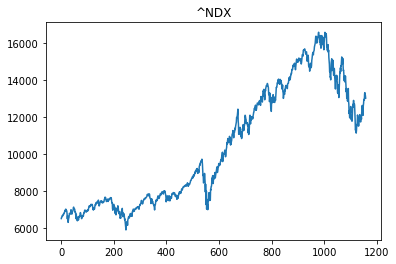

In [32]:
df1=data.reset_index()['Close']
df1.plot(title=asset)

In [33]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.05733468],
       [0.06337365],
       [0.06419624],
       ...,
       [0.68468684],
       [0.68014025],
       [0.66665884]])

In [34]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
train_data.shape, test_data.shape

((753, 1), (406, 1))

# Data Preprocessing

In [35]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(dataset.shape[0]-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((652, 100), (652,), (305, 100), (305,))

In [36]:
X_train

array([[0.05733468, 0.06337365, 0.06419624, ..., 0.09314886, 0.09877092,
        0.09840276],
       [0.06337365, 0.06419624, 0.07063338, ..., 0.09877092, 0.09840276,
        0.09945389],
       [0.06419624, 0.07063338, 0.07281999, ..., 0.09840276, 0.09945389,
        0.09623299],
       ...,
       [0.46904015, 0.48301808, 0.48690228, ..., 0.64200075, 0.64070041,
        0.636211  ],
       [0.48301808, 0.48690228, 0.48960983, ..., 0.64070041, 0.636211  ,
        0.6387686 ],
       [0.48690228, 0.48960983, 0.50287944, ..., 0.636211  , 0.6387686 ,
        0.63273337]])

# LSTM Model

In [37]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
X_train

array([[[0.05733468],
        [0.06337365],
        [0.06419624],
        ...,
        [0.09314886],
        [0.09877092],
        [0.09840276]],

       [[0.06337365],
        [0.06419624],
        [0.07063338],
        ...,
        [0.09877092],
        [0.09840276],
        [0.09945389]],

       [[0.06419624],
        [0.07063338],
        [0.07281999],
        ...,
        [0.09840276],
        [0.09945389],
        [0.09623299]],

       ...,

       [[0.46904015],
        [0.48301808],
        [0.48690228],
        ...,
        [0.64200075],
        [0.64070041],
        [0.636211  ]],

       [[0.48301808],
        [0.48690228],
        [0.48960983],
        ...,
        [0.64070041],
        [0.636211  ],
        [0.6387686 ]],

       [[0.48690228],
        [0.48960983],
        [0.50287944],
        ...,
        [0.636211  ],
        [0.6387686 ],
        [0.63273337]]])

In [39]:
model=Sequential()
# https://keras.io/api/layers/activations/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM 
# sigmoid by default
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) #, activation='tanh'
# model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True)) #, activation='tanh'
model.add(LSTM(50))
model.add(Dense(1))
# https://keras.io/api/optimizers/
# model.compile(loss='mean_squared_error',optimizer='adam')# adaptive moment estimation GOOD
# model.compile(loss='mean_squared_error',optimizer='SGD')# Stochastic Gradient Descendent BAD
model.compile(loss='mean_squared_error',optimizer='RMSprop')# Root Mean Squared Propagation BEST
# model.compile(loss='mean_squared_error',optimizer='Adagrad')# Adaptive Gradient Algorithm VERY BAD
# model.compile(loss='mean_squared_error',optimizer='Adadelta')# adapts learning rates VERY BAD
# model.compile(loss='mean_squared_error',optimizer='Adamax')# Adam based on the infinity norm OK
# model.compile(loss='mean_squared_error',optimizer='Nadam')# Nesterov-accelerated Adaptive Moment Estimation OK
# model.compile(loss='mean_squared_error',optimizer='Ftrl')# Follow The Regularized Leader NA
# https://keras.io/api/losses/
# model.compile(loss='huber',optimizer='RMSprop')# OK
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
11/11 [==============================] - 9s 259ms/step - loss: 0.0154 - val_loss: 0.0134
Epoch 2/100
11/11 [==============================] - 1s 128ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/100
11/11 [==============================] - 1s 126ms/step - loss: 0.0026 - val_loss: 0.0177
Epoch 4/100
11/11 [==============================] - 1s 124ms/step - loss: 0.0019 - val_loss: 0.0856
Epoch 5/100
11/11 [==============================] - 1s 126ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 6/100
11/11 [==============================] - 1s 124ms/step - loss: 0.0019 - val_loss: 0.0268
Epoch 7/100
11/11 [==============================] - 1s 128ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 8/100
11/11 [==============================] - 1s 125ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 9/100
11/11 [==============================] - 1s 130ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 10/100
11/11 [==============================] - 1s 131ms/step - loss: 0.0030 - val_lo

11/11 [==============================] - 2s 207ms/step - loss: 2.6347e-04 - val_loss: 7.4061e-04
Epoch 80/100
11/11 [==============================] - 2s 198ms/step - loss: 5.8171e-04 - val_loss: 8.3999e-04
Epoch 81/100
11/11 [==============================] - 2s 212ms/step - loss: 2.0559e-04 - val_loss: 7.6205e-04
Epoch 82/100
11/11 [==============================] - 2s 214ms/step - loss: 5.6055e-04 - val_loss: 0.0010
Epoch 83/100
11/11 [==============================] - 2s 204ms/step - loss: 4.7393e-04 - val_loss: 0.0050
Epoch 84/100
11/11 [==============================] - 2s 218ms/step - loss: 3.0448e-04 - val_loss: 9.6316e-04
Epoch 85/100
11/11 [==============================] - 2s 217ms/step - loss: 7.0752e-04 - val_loss: 0.0020
Epoch 86/100
11/11 [==============================] - 2s 214ms/step - loss: 3.4812e-04 - val_loss: 0.0128
Epoch 87/100
11/11 [==============================] - 2s 218ms/step - loss: 3.4826e-04 - val_loss: 0.0045
Epoch 88/100
11/11 [=======================

In [41]:
y_train=scaler.inverse_transform(np.array(y_train).reshape(-1,1))
y_test=scaler.inverse_transform(np.array(y_test).reshape(-1,1))

In [42]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

10/10 [==============================] - 0s 25ms/step


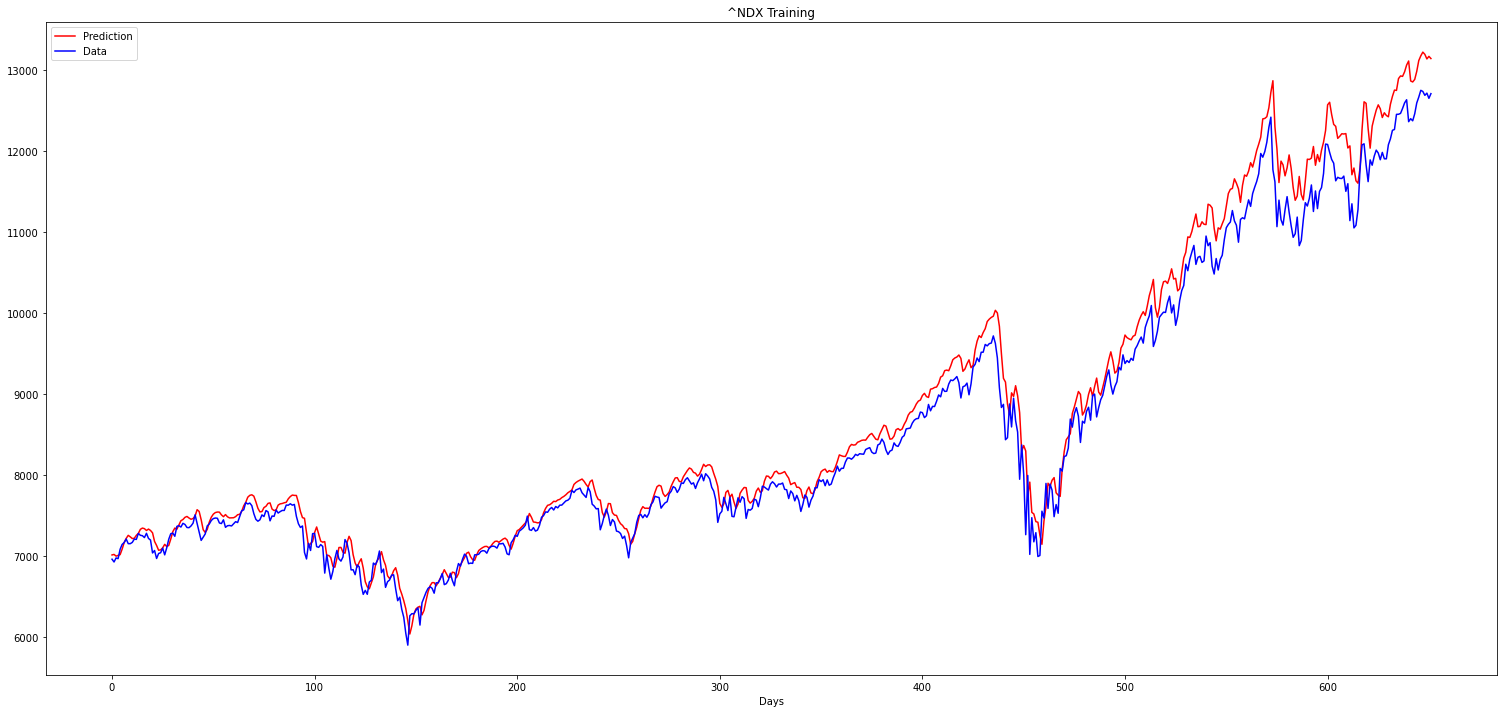

In [43]:
plt.figure(figsize=(26,12))
plt.plot(train_predict,color='red',label='Prediction')
plt.plot(y_train,color='blue',label='Data')
# plt.gca().xaxis.set_major_locator(years)
plt.xlabel('Days')
plt.title(asset+" Training")
plt.legend(loc='best')
plt.show()

In [44]:
round(math.sqrt(mean_squared_error(y_train,train_predict)),2)

281.31

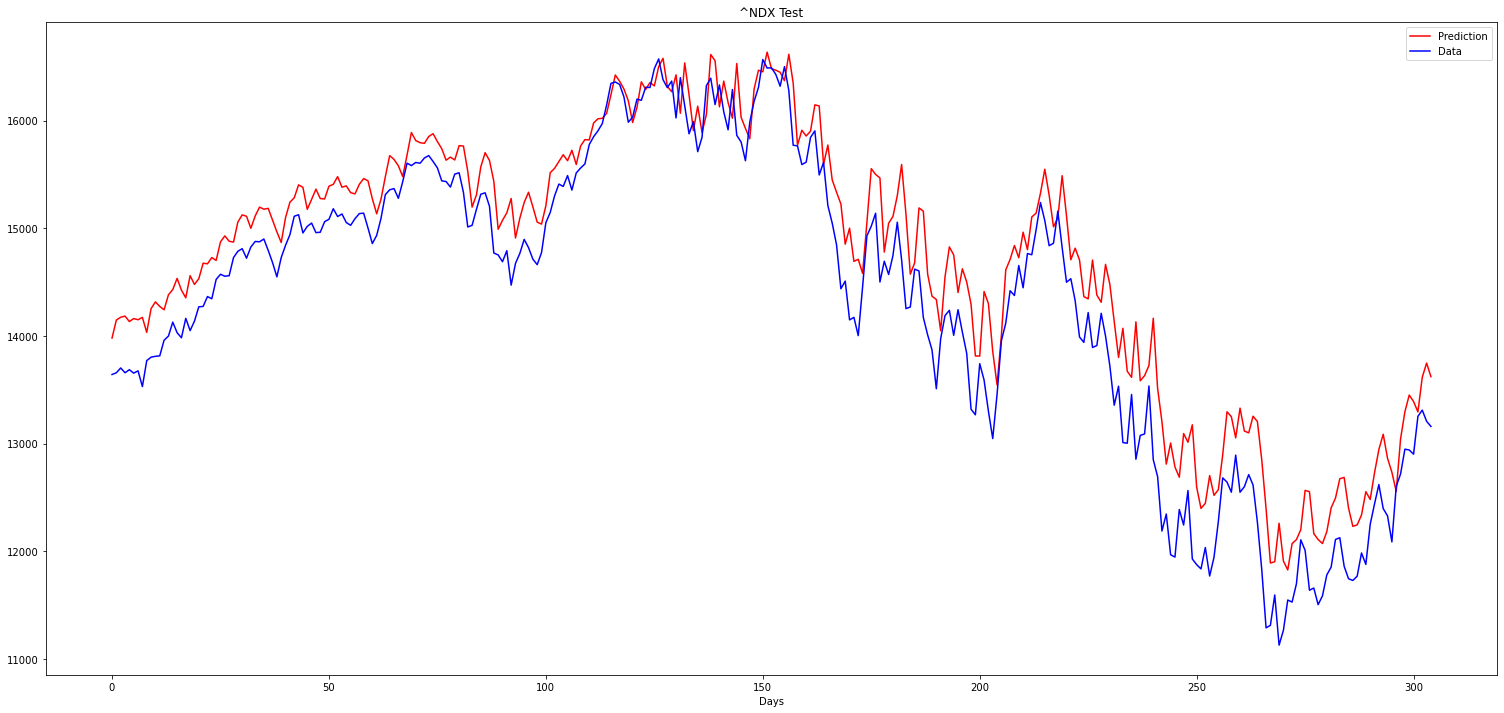

In [45]:
plt.figure(figsize=(26,12))
plt.plot(test_predict,color='red',label='Prediction')
plt.plot(y_test,color='blue',label='Data')
# plt.gca().xaxis.set_major_locator(years)
plt.xlabel('Days')
plt.title(asset+" Test")
plt.legend(loc='best')
plt.show()

In [46]:
round(math.sqrt(mean_squared_error(y_test, test_predict)),2)

466.9

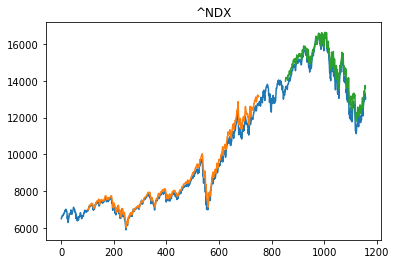

In [47]:
# Plotting
# Shift train predictionis for plotting

look_back = time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict


# Shif test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1: len(df1)-1,:] = test_predict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title(asset)
plt.show()

# Forecasting - 10 Days Ahead

In [48]:
len(test_data)

406

In [49]:
X_input = test_data[len(test_data)-time_step:].reshape(1,-1)
X_input.shape

(1, 100)

In [50]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [51]:
# Demonstrate prediction for next 10 days

lst_output = []
n_steps = time_step
i = 0
days_ahead = 10

while(i<days_ahead):
  if(len(temp_input) > time_step):
    # print(temp_input)
    X_input = np.array(temp_input[1:])
#     print(" {} day input {}".format(i, X_input))
    X_input = X_input.reshape(1,-1)
    X_input = X_input.reshape((1, n_steps, 1))

    # print(X_input)
    yhat = model.predict(X_input, verbose = 0)
#     print("{} day output {}".format(i, yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]

    # print(temp_input)
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    X_input = X_input.reshape((1, n_steps, 1))
    yhat = model.predict(X_input, verbose = 0)
#     print(yhat[0])
    temp_input.extend(yhat[0].tolist())
#     print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1

# print(lst_output)

In [52]:
day_new = np.arange(1,time_step+1)
day_pred = np.arange(time_step+1, time_step+1+days_ahead)

In [53]:
len(df1)

1159

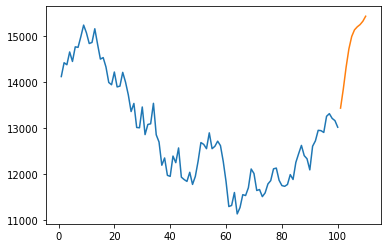

In [54]:
plt.plot(day_new, scaler.inverse_transform(df1[len(df1)-time_step:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.show()